In [31]:
# proje boyunca kullanacağımız tüm kütüphaneleri buraya ekledim.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import DBSCAN

# uyarıları kapatıyorum ki çıktı temiz görünsün
warnings.filterwarnings('ignore')

# Pandas ayarları: Tüm sütunları görmek ve sayıları düzgün formatta okumak için
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

print("Kütüphaneler başarıyla yüklendi.")

Kütüphaneler başarıyla yüklendi.


In [32]:
# veri setimizi pandas ile okuyorum
try:
    df_raw = pd.read_csv('ekip_odevi_ham_veri_30k.csv')
    print(f"Veri seti yüklendi. Boyut: {df_raw.shape}")
except FileNotFoundError:
    print("Hata: Dosya bulunamadı. Lütfen dosya yolunu kontrol edin.")

print("\nVeriye genel bir bakış (İlk 5 satır):")
display(df_raw.head())

Veri seti yüklendi. Boyut: (30000, 17)

Veriye genel bir bakış (İlk 5 satır):


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,marka,tax(£),fuel type,engine size,mileage2,fuel type2,engine size2,reference
0,Kamiq,2019.00,21990,Semi-Auto,563,Diesel,145.00,52.30,1.60,skoda,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Q5,2016.00,20498,Semi-Auto,33657,Diesel,200.00,47.10,2.00,audi,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Touareg,2019.00,39995,Semi-Auto,7000,Diesel,145.00,34.50,3.00,vw,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Aygo,2019.00,8690,Manual,2438,Petrol,145.00,56.50,1.00,toyota,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,S-MAX,2020.00,34498,Semi-Auto,4623,Diesel,145.00,43.50,2.00,ford,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# hangi sütunda ne kadar eksik veri var, veri tipleri ne durumda? bunu görmek için bir özet tablo hazırladım

print("\nVeri setine teknik bakış (Özet Tablo):")

ozet_tablo = pd.DataFrame({
    'Veri Tipi': df_raw.dtypes,
    'Toplam Satır': len(df_raw),
    'Dolu Veri': df_raw.count(),
    'Eksik Veri': df_raw.isnull().sum(),
    'Eksiklik Oranı (%)': (df_raw.isnull().sum() / len(df_raw) * 100).round(2),
    'Benzersiz Değer Sayısı': df_raw.nunique()
})

# eksik verileri kırmızı tonlarıyla vurguluyoruz
display(ozet_tablo.style.background_gradient(cmap='Reds', subset=['Eksik Veri']))


Veri setine teknik bakış (Özet Tablo):


,Veri Tipi,Toplam Satır,Dolu Veri,Eksik Veri,Eksiklik Oranı (%),Benzersiz Değer Sayısı
model,object,30000,29965,35,0.120000,179
year,float64,30000,29946,54,0.180000,24
price,object,30000,29965,35,0.120000,7703
transmission,object,30000,29965,35,0.120000,4
mileage,object,30000,29735,265,0.880000,20045
fuelType,object,30000,27520,2480,8.270000,4
tax,float64,30000,23967,6033,20.110000,39
mpg,float64,30000,25191,4809,16.030000,166
engineSize,float64,30000,27520,2480,8.270000,33
marka,object,30000,30000,0,0.000000,13


In [34]:
# istatistiksel Özet (Describe)
# sayısal verilerin dağılımına, ortalamasına ve standart sapmasına bakıyorum
# aykırı değerler hakkında ilk ipuçlarını buradan alabiliriz
print("\nSayısal verilerin istatistiksel bakışı:")
display(df_raw.describe().T)


Sayısal verilerin istatistiksel bakışı:


,count,mean,std,min,25%,50%,75%,max
year,29946.00,2017.11,2.12,1996.00,2016.00,2017.00,2019.00,2020.00
tax,23967.00,119.85,62.97,0.00,125.00,145.00,145.00,580.00
mpg,25191.00,55.22,16.46,1.10,47.10,54.30,62.80,470.80
engineSize,27520.00,1.66,0.55,0.00,1.20,1.60,2.00,6.20
tax(£),1224.00,122.05,58.92,0.00,125.00,145.00,145.00,555.00


In [35]:
# kategorik Değişkenlerin Özeti
# marka, model, yakıt tipi gibi sözel verilerin durumu nedir? en çok tekrar edenler hangileri? bakıyorum
try:
    print("\nKategorik Değişkenlerin Özeti (En sık geçen değerler):")
    # Sadece object (metin) tipindeki sütunları dahil ediyoruz
    display(df_raw.describe(include='object').T)
except ValueError:
    print("Veri setinde kategorik değişken bulunamadı.")


Kategorik Değişkenlerin Özeti (En sık geçen değerler):


,count,unique,top,freq
model,29965,179,Focus,3932
price,29965,7703,9995,149
transmission,29965,4,Manual,16824
mileage,29735,20045,1000,225
fuelType,27520,4,Petrol,15180
marka,30000,13,ford,4591
fuel type,894,38,Petrol,147
engine size,2414,38,£145,1248
mileage2,2428,190,60.1,311
fuel type2,2215,4,Petrol,1170


In [36]:
# tekrar Eden Veri (duplicate) kontrolü
# aynı satırdan birden fazla varsa modelin kafasını karıştırabilir, bunları tespit ediyorum
tekrar_sayisi = df_raw.duplicated().sum()
print(f"\nTEKRAR EDEN SATIR SAYISI: {tekrar_sayisi}")

if tekrar_sayisi > 0:
    print("Bu tekrarlar temizlik aşamasında silinecek.")


TEKRAR EDEN SATIR SAYISI: 301
Bu tekrarlar temizlik aşamasında silinecek.


In [37]:
# veri temizliği fonksiyonum
# veri setindeki kirli karakterleri temizlemek ve sayısal dönüşümler için fonksiyon yazıyorum

def robust_clean(df_input):
    df = df_input.copy()
    
    # string (object) kolonları temizliyoruz
    for col in df.select_dtypes(include=['object']).columns:
        # para birimi işaretlerini ve virgülleri kaldırıp boşlukları temizliyorum
        df[col] = df[col].astype(str).str.replace(r'[£$€,]', '', regex=True).str.strip()
        
        # "nan" veya "None" gibi string olarak gelmiş boş değerleri gerçek NaN yapıyorum
        df[col] = df[col].replace({'nan': np.nan, 'None': np.nan, '': np.nan})

    # sayısal olması gereken ama string görünen kolonları dönüştürüyorum
    # errors='coerce' diyerek dönüşemeyenleri NaN yapıyoruz ki kod patlamasın
    numeric_candidates = ['price', 'mileage', 'tax', 'mpg', 'engineSize']
    for col in numeric_candidates:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    return df

if 'df_raw' in locals():
    print("Veri temizliği ve filtreleme işlemi başlatılıyor...")
    
    df_clean = df_raw.copy()
    df_clean = robust_clean(df_clean)
    
    # tekrar eden satırları siliyorum
    ilk_boyut = len(df_clean)
    df_clean = df_clean.drop_duplicates().reset_index(drop=True)
    silinen = ilk_boyut - len(df_clean)
    
    print(f"- Temizlik tamamlandı.")
    print(f"- {silinen} adet tekrar eden kayıt silindi.")
    print(f"- Yeni Veri Seti Boyutu: {df_clean.shape}")
    
    # veri tiplerine bakalım
    print("\nTemizlik Sonrası Kritik Sütunların Veri Tipleri:")
    print(df_clean[['price', 'mileage', 'tax', 'mpg', 'engineSize']].dtypes)
    
    display(df_clean.head())

else:
    print("HATA: 'df_raw' bulunamadı.")

Veri temizliği ve filtreleme işlemi başlatılıyor...
- Temizlik tamamlandı.
- 301 adet tekrar eden kayıt silindi.
- Yeni Veri Seti Boyutu: (29699, 17)

Temizlik Sonrası Kritik Sütunların Veri Tipleri:
price         float64
mileage       float64
tax           float64
mpg           float64
engineSize    float64
dtype: object


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,marka,tax(£),fuel type,engine size,mileage2,fuel type2,engine size2,reference
0,Kamiq,2019.00,21990.00,Semi-Auto,563.00,Diesel,145.00,52.30,1.60,skoda,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Q5,2016.00,20498.00,Semi-Auto,33657.00,Diesel,200.00,47.10,2.00,audi,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Touareg,2019.00,39995.00,Semi-Auto,7000.00,Diesel,145.00,34.50,3.00,vw,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Aygo,2019.00,8690.00,Manual,2438.00,Petrol,145.00,56.50,1.00,toyota,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,S-MAX,2020.00,34498.00,Semi-Auto,4623.00,Diesel,145.00,43.50,2.00,ford,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
# fiyatı çok düşük veya çok yüksek olanları, yılı çok eski olanları eliyorum

# önce garanti olsun diye sayıya çeviriyorum (yukarıda yapmıştık ama tekrar kontrol)
df_clean['price'] = pd.to_numeric(df_clean['price'], errors='coerce')
df_clean['year']  = pd.to_numeric(df_clean['year'], errors='coerce')

# NaN olan fiyat veya yıl varsa siliyorum, bunlar modelde işe yaramaz
df_clean = df_clean.dropna(subset=['price', 'year'])

print("Aykırı değer temizliği başlıyor...")
filtre_oncesi = len(df_clean)

# mantıklı aralıktaki verileri tutuyorum (Örnek fiyatı 100'den büyük 200k'dan küçük)
df_clean = df_clean[
    (df_clean['price'] > 100) & 
    (df_clean['price'] < 200000) & 
    (df_clean['year'] > 1995)
]

silinen_adet = filtre_oncesi - len(df_clean)
print(f"- Filtreleme sonucu {silinen_adet} adet aykırı veri elendi.")
print(f"\nAnalize hazır veri boyutu: {df_clean.shape}")

Aykırı değer temizliği başlıyor...
- Filtreleme sonucu 0 adet aykırı veri elendi.

Analize hazır veri boyutu: (29678, 17)


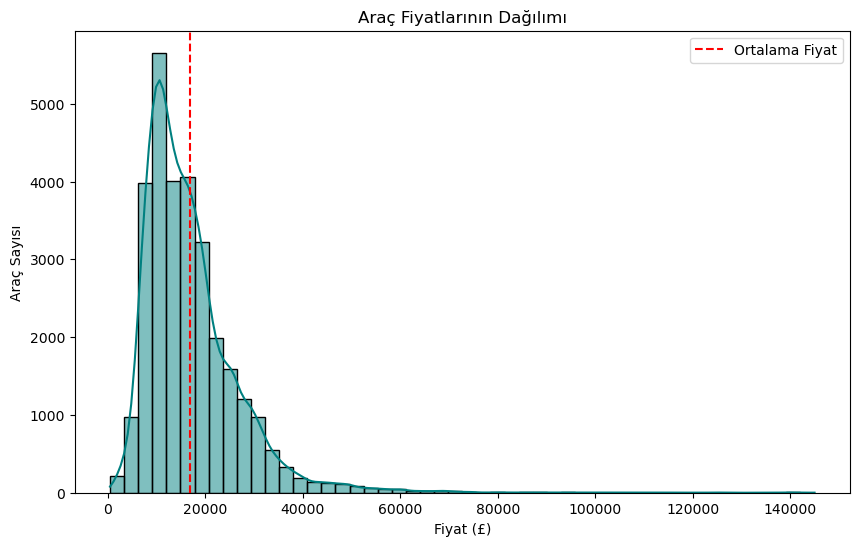

In [39]:
# fiyat dağılım grafiğine bakıyorum
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['price'], bins=50, kde=True, color='teal')
plt.title('Araç Fiyatlarının Dağılımı')
plt.xlabel('Fiyat (£)')
plt.ylabel('Araç Sayısı')
plt.axvline(df_clean['price'].mean(), color='red', linestyle='--', label='Ortalama Fiyat')
plt.legend()
plt.show()

In [40]:
# baseline model hazırlığı yapıyorum
# burada karmaşık feature engineering yapmadan, sadece label encoding ile basit bir deneme yapıyorum

print("Baseline model için veri hazırlanıyor...")

# temizlenmiş verinin kopyasını alıyoruz
df_base = df_clean.copy()

# kategorik verileri basitçe sayıya çeviriyoruz (label encoding)
cat_cols = df_base.select_dtypes(include=['object']).columns
for col in cat_cols:
    df_base[col] = df_base[col].astype('category').cat.codes

# hedef ve özelliklerin ayrılması
X_base = df_base.drop('price', axis=1)
y_base = df_base['price']

# train ve test split
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_base, y_base, test_size=0.2, random_state=42)

print("Veri seti ayrıldı:")
print(f"- Eğitim Seti (Train): {X_train_b.shape}")
print(f"- Test Seti (Test)   : {X_test_b.shape}")

Baseline model için veri hazırlanıyor...
Veri seti ayrıldı:
- Eğitim Seti (Train): (23742, 16)
- Test Seti (Test)   : (5936, 16)


In [41]:
# baseline modellerin eğitimi ve sonuçları

if 'X_train_b' not in locals() or 'y_train_b' not in locals():
    raise ValueError("Eğitim verisi bulunamadı!")

print("Baseline modeller eğitiliyor...")

# Basit modellerim decision tree ve bayesian ridge 
base_models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Bayesian Ridge": BayesianRidge()
}

baseline_results = []

for name, model in base_models.items():
    # pipeline kuruyorum. önce eksikleri doldurup sonra ölçekleyip sonra modelliyorum
    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')), 
        ('scaler', StandardScaler()), 
        ('model', model)
    ])
    
    # eğitme
    pipe.fit(X_train_b, y_train_b)
    
    # tahmin etme
    y_pred = pipe.predict(X_test_b)
    
    # skorlama
    r2 = r2_score(y_test_b, y_pred)
    mae = mean_absolute_error(y_test_b, y_pred)
    
    baseline_results.append({
        "Model": name,
        "R2 Skoru": r2, 
        "MAE (Ortalama Hata)": mae
    })

# sonuçları tabloya döküyorum
df_base_results = pd.DataFrame(baseline_results)
print("\nBaseline Model Sonuçları:")
display(df_base_results.sort_values(by="R2 Skoru", ascending=False).style.background_gradient(cmap="Greens"))

Baseline modeller eğitiliyor...

Baseline Model Sonuçları:


,Model,R2 Skoru,MAE (Ortalama Hata)
0,Decision Tree,0.886618,1825.328195
1,Bayesian Ridge,0.708180,3550.245628


In [42]:
# feature engineering
# veriden yeni anlamlı özellikler türetiyoruz. bu aşama model performansını artırır

if 'df_clean' in locals():
    df_eng = df_clean.copy()
else:
    print("df_clean bulunamadı, işlemler atlanıyor.")
    df_eng = pd.DataFrame() # Hata vermesin diye boş

# Mileage sütununu garanti sayıya çevir
df_eng['mileage'] = pd.to_numeric(df_eng['mileage'], errors='coerce')

print("Özellik mühendisliği başlıyor...")

Özellik mühendisliği başlıyor...


In [43]:
# yeni özellikler türetiyorum
# araç yaş
df_eng['age'] = 2025 - df_eng['year']

# yıllık ortalama kullanım
# 0'a bölme hatası olmasın diye yaşı 0 olanları 1 kabul ediyorum
df_eng['avg_km_per_year'] = df_eng['mileage'] / df_eng['age'].replace(0, 1)

print("Yeni özellikler eklendi: 'age', 'avg_km_per_year'")

Yeni özellikler eklendi: 'age', 'avg_km_per_year'


In [44]:
# türetme sonrası temizlik
# 'year' bilgisini artık 'age' içinde taşıyorum, 'year'ı çıkarabilirim (multicollinearity önlemek için).
df_eng = df_eng.drop(columns=['year'])

limit = len(df_eng) * 0.5
df_eng = df_eng.dropna(thresh=limit, axis=1)

# bölme işleminden kaynaklı sonsuz (inf) veya boş (NaN) değerler oluştuysa temizliyorum
df_eng.replace([np.inf, -np.inf], np.nan, inplace=True)

kritik_sutunlar = ['price', 'age', 'mileage', 'avg_km_per_year']

mevcut_kritik = [col for col in kritik_sutunlar if col in df_eng.columns]

df_eng.dropna(subset=mevcut_kritik, inplace=True)

print(f"İşlem sonrası veri boyutu: {df_eng.shape}")
print("\nYeni özelliklerle veri seti örneği:")
display(df_eng[['price', 'age', 'mileage', 'avg_km_per_year']].head())

İşlem sonrası veri boyutu: (29447, 11)

Yeni özelliklerle veri seti örneği:


,price,age,mileage,avg_km_per_year
0,21990.00,6.00,563.00,93.83
1,20498.00,9.00,33657.00,3739.67
2,39995.00,6.00,7000.00,1166.67
3,8690.00,6.00,2438.00,406.33
4,34498.00,5.00,4623.00,924.60


In [45]:
# eksik veri kaldı mı bakıyorum
print(f"Veri setindeki toplam boş değer sayısı: {df_eng.isnull().sum().sum()}")

Veri setindeki toplam boş değer sayısı: 14430


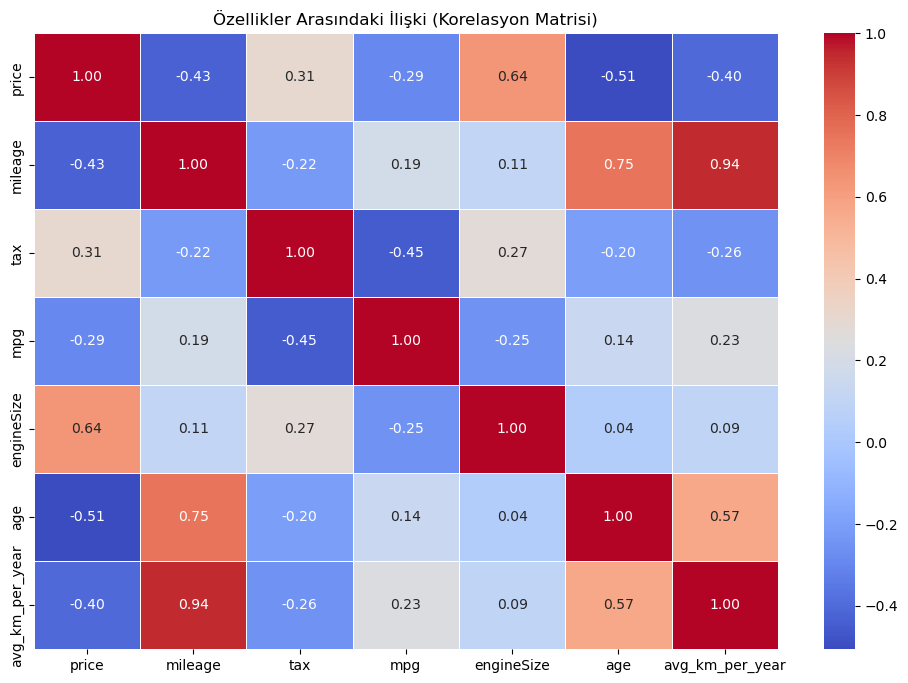

In [46]:
# korelasyon Analizi
# yeni türettiğimiz özelliklerin fiyatla ve birbirleriyle ilişkisine bakıyorum

plt.figure(figsize=(12, 8))
numeric_cols = df_eng.select_dtypes(include=np.number)
sns.heatmap(numeric_cols.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Özellikler Arasındaki İlişki (Korelasyon Matrisi)')
plt.show()

In [47]:
# modelin kategorik verileri daha iyi anlaması için One-Hot Encoding yapıyoruz.

print("One-Hot Encoding yapılıyor...")

if 'df_eng' in locals() and len(df_eng) > 0:
    df_model = df_eng.copy()
else:
    df_model = df_clean.copy()

# One-Hot Encoding: kategorik verileri 0-1 sütunlarına çevirir.
# drop_first=true diyerek dummy variable tuzağından kaçınıyoruz.
df_encoded = pd.get_dummies(df_model, drop_first=True)

# hedef ve özellik Ayrımı
X = df_encoded.drop('price', axis=1)
y = df_encoded['price']

# eğitim ve test seti ayrımı (%80 - %20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nVeri seti başarıyla hazırlandı ve bölündü:")
print(f"- Eğitim Seti Boyutu (X_train): {X_train.shape} (Sütun sayısı One-Hot ile arttı)")
print(f"- Test Seti Boyutu  (X_test) : {X_test.shape}")

One-Hot Encoding yapılıyor...

Veri seti başarıyla hazırlandı ve bölündü:
- Eğitim Seti Boyutu (X_train): (23557, 202) (Sütun sayısı One-Hot ile arttı)
- Test Seti Boyutu  (X_test) : (5890, 202)


In [48]:
# model karşılaştırması (feature selection öncesi)
# One-Hot encoded veri ile modelleri tekrar deniyorum

print("One-Hot Encoded veri ile modeller test ediliyor...")

# decision tree
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
preds_dt = dt_model.predict(X_test)
r2_dt = r2_score(y_test, preds_dt)
mae_dt = mean_absolute_error(y_test, preds_dt)

# bayesian ridge (pipeline içinde çünkü scaling ister)
model_br = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler()), 
    ('model', BayesianRidge())
])
model_br.fit(X_train, y_train)
preds_br = model_br.predict(X_test)
r2_br = r2_score(y_test, preds_br)
mae_br = mean_absolute_error(y_test, preds_br)

# sonuçları karşılaştıralım
results_df = pd.DataFrame({
    'Model': ['Decision Tree', 'Bayesian Ridge'],
    'R2 Score': [r2_dt, r2_br],  
    'MAE': [mae_dt, mae_br]
})

print("\nFeature Selection Öncesi Model Performansı:")
display(results_df.style.background_gradient(cmap='Greens', subset=['R2 Score']))

One-Hot Encoded veri ile modeller test ediliyor...

Feature Selection Öncesi Model Performansı:


,Model,R2 Score,MAE
0,Decision Tree,0.896903,1894.687436
1,Bayesian Ridge,0.867499,2294.246005


In [49]:
# feature selection ve boyut indirgeme
# önce eksik verileri dolduruyorum (one-hot sonrası NaN oluşmuş olabilir)

imputer = SimpleImputer(strategy='mean')
# sütun isimlerini kaybetmemek için dataframe'e geri çeviriyorum
X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# ölçeklendirme (pcave lineer modeller için şart)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

# selectKBest (istatistiksel seçim)
# en iyi 10 özelliği seçiyorum
print("Yöntem 1: SelectKBest ile en iyi 10 özellik seçiliyor...")
selector = SelectKBest(score_func=f_regression, k=10)
X_train_sel = selector.fit_transform(X_train_scaled, y_train)
X_test_sel = selector.transform(X_test_scaled)

# seçilen özelliklerin isimlerini görelim
selected_mask = selector.get_support()
selected_feat_names = X_train.columns[selected_mask]
print(f"-> Seçilen Özellikler: {list(selected_feat_names)}")

# PCA (Principal Component Analysis - boyut indirgeme)
# verinin varyansının %95'ini koruyacak kadar bileşene indirgiyoruz
print("\nYöntem 2: PCA ile Boyut İndirgeme yapılıyor...")
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"-> Orijinal Özellik Sayısı: {X_train.shape[1]}")
print(f"-> PCA Sonrası Bileşen Sayısı: {X_train_pca.shape[1]}")

Yöntem 1: SelectKBest ile en iyi 10 özellik seçiliyor...
-> Seçilen Özellikler: ['mileage', 'tax', 'mpg', 'engineSize', 'age', 'avg_km_per_year', 'transmission_Manual', 'transmission_Semi-Auto', 'marka_merc', 'marka_vauxhall']

Yöntem 2: PCA ile Boyut İndirgeme yapılıyor...
-> Orijinal Özellik Sayısı: 202
-> PCA Sonrası Bileşen Sayısı: 173


In [50]:
# farklı veri setleri ile model karşılaştırması
print("Farklı veri setleri üzerinde modeller test ediliyor...")

models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Bayesian Ridge": BayesianRidge()
}

datasets = {
    "1. Tüm Özellikler (Scaled)": (X_train_scaled, X_test_scaled),
    "2. SelectKBest (10 Özellik)": (X_train_sel, X_test_sel),
    "3. PCA (İndirgenmiş)": (X_train_pca, X_test_pca)
}

final_results = []

for model_name, model in models.items():
    for data_name, (X_tr, X_te) in datasets.items():
        
        # eğitme
        model.fit(X_tr, y_train)
        
        # tahmin
        preds = model.predict(X_te)
        
        # skor
        r2 = r2_score(y_test, preds)
        mae = mean_absolute_error(y_test, preds)
        
        final_results.append({
            "Model": model_name,
            "Yöntem": data_name,
            "R2 Score": r2,
            "MAE (Hata)": mae,
            "Özellik Sayısı": X_tr.shape[1]
        })

df_results = pd.DataFrame(final_results)

print("\nFarklı Yöntemlerin Karşılaştırması:")
# pivot tablo ile daha net görelim
pivot_table = df_results.pivot(index="Model", columns="Yöntem", values="R2 Score")
display(pivot_table.style.background_gradient(cmap='YlGn', axis=None).format("{:.4f}"))

# detaylı tablo
display(df_results.sort_values(by="R2 Score", ascending=False).style.background_gradient(cmap='Greens', subset=['R2 Score']))

Farklı veri setleri üzerinde modeller test ediliyor...

Farklı Yöntemlerin Karşılaştırması:


Yöntem,1. Tüm Özellikler (Scaled),2. SelectKBest (10 Özellik),3. PCA (İndirgenmiş)
Model,,,
Bayesian Ridge,0.8675,0.7546,0.7946
Decision Tree,0.8972,0.8333,0.8761


,Model,Yöntem,R2 Score,MAE (Hata),Özellik Sayısı
0,Decision Tree,1. Tüm Özellikler (Scaled),0.897239,1907.356593,202
2,Decision Tree,3. PCA (İndirgenmiş),0.876126,2024.951868,173
3,Bayesian Ridge,1. Tüm Özellikler (Scaled),0.867499,2294.246005,202
1,Decision Tree,2. SelectKBest (10 Özellik),0.833338,2384.847213,10
5,Bayesian Ridge,3. PCA (İndirgenmiş),0.794551,2911.229283,173
4,Bayesian Ridge,2. SelectKBest (10 Özellik),0.754571,3205.366119,10


In [51]:
# Grid Searchs
# en iyi sonucu veren model için en iyi parametreleri arıyorum
# SelectKBest ile seçilmiş veriyi kullanıyoruz çünkü daha hızlı çalışır

print("Decision Tree için Hiperparametre Optimizasyonu (Grid Search)...")

# parametre belirleme
param_grid = {
    'max_depth': [None, 10, 15, 20, 30],         # Ağaç derinliği
    'min_samples_split': [2, 5, 10, 20],         # Bölünme için min örnek
    'min_samples_leaf': [1, 2, 4]                # Yaprak için min örnek
}

# grid search kurulumu
dt_base = DecisionTreeRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=dt_base,
    param_grid=param_grid,
    cv=5,                 # 5 katlı çapraz doğrulama (Cross-Validation)
    scoring='r2',         # başarı kriterimiz R2
    n_jobs=-1,            # tüm işlemcileri kullan
    verbose=1
)

# modeli SelectKBest verisi ile eğitiyoruz
grid_search.fit(X_train_sel, y_train)

# en iyi model ve parametreler
dt_opt = grid_search.best_estimator_
print(f"\nBulunan en iyi parametreler: {grid_search.best_params_}")

# test seti üzerinde performans
preds_opt = dt_opt.predict(X_test_sel)
r2_opt = r2_score(y_test, preds_opt)
mae_opt = mean_absolute_error(y_test, preds_opt)

print(f"Optimize Edilmiş Decision Tree R2 Skoru : {r2_opt:.4f}")
print(f"Optimize Edilmiş Hata (MAE)             : {mae_opt:.2f}")

Decision Tree için Hiperparametre Optimizasyonu (Grid Search)...
Fitting 5 folds for each of 60 candidates, totalling 300 fits

Bulunan en iyi parametreler: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 20}
Optimize Edilmiş Decision Tree R2 Skoru : 0.8839
Optimize Edilmiş Hata (MAE)             : 2061.42


Proje Final Tablosu:


,Model Aşaması,R2 Skoru,Gelişim (Base DT'ye Göre)
0,1. Decision Tree (Base),0.896903,0.000000
1,2. Bayesian Ridge (Base),0.867499,-0.029404
2,3. Optimize DT (Final),0.883873,-0.013030


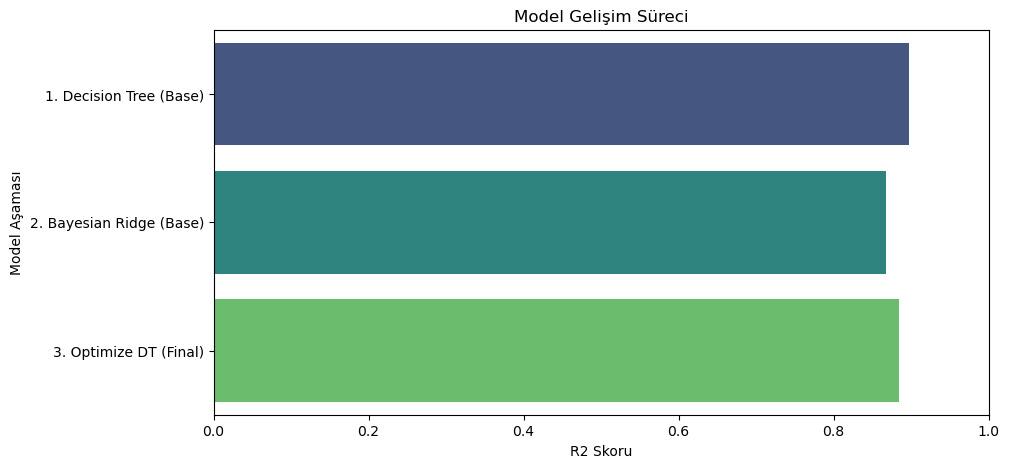

In [52]:
# proje sonucu ve karşılaştırma
# base model ile optimize edilmiş modelin farkını gösteriyoruz

print("Proje Final Tablosu:")

# değişkenler hafızada yoksa (hata durumunda) 0 ata
score_br = r2_br if 'r2_br' in locals() else 0
score_dt = r2_dt if 'r2_dt' in locals() else 0
# optimize skoru r2_opt'dan gelir
score_opt_final = r2_opt if 'r2_opt' in locals() else 0

# tablo oluşturma
final_compare = pd.DataFrame({
    'Model Aşaması': ['1. Decision Tree (Base)', '2. Bayesian Ridge (Base)', '3. Optimize DT (Final)'],
    'R2 Skoru': [score_dt, score_br, score_opt_final],
    'Gelişim (Base DT\'ye Göre)': [0, score_br - score_dt, score_opt_final - score_dt]
})

display(final_compare.style.background_gradient(cmap='Greens', subset=['R2 Skoru']))

# grafik
plt.figure(figsize=(10, 5))
sns.barplot(x='R2 Skoru', y='Model Aşaması', data=final_compare, palette='viridis')
plt.title('Model Gelişim Süreci')
plt.xlim(0, 1.0)
plt.show()

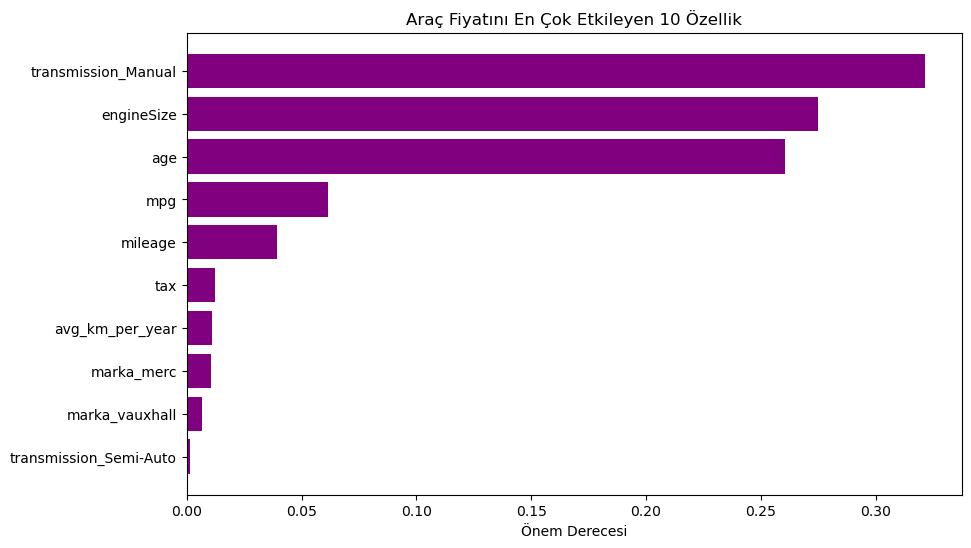

In [53]:
# modelin karar verirken en çok hangi özelliklere baktığını çiziyoruz

# sadece SelectKBest kullandıysak o özellikleri alalım
feature_names = X_train.columns[selector.get_support()]

# önem puanları
importances = dt_opt.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title('Araç Fiyatını En Çok Etkileyen 10 Özellik')
plt.barh(range(len(indices)), importances[indices], color='purple')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Önem Derecesi')
plt.show()

Hataların Analizi (Residual Plot)


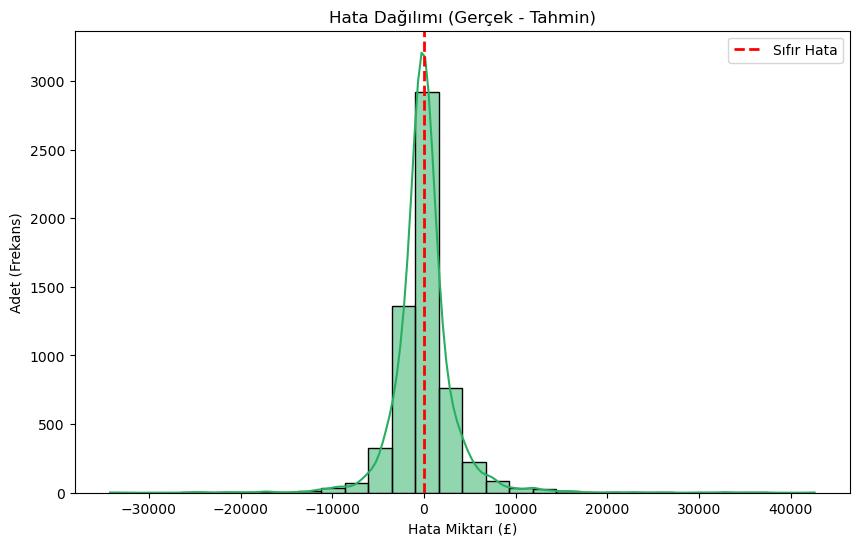

In [54]:
# hata analizi (Residuals Plot)
# tahminlerin gerçek değerden ne kadar saptığını gösteren grafik.
# Hataların 0 etrafında normal dağılması (çan eğrisi) modelin iyi olduğunu gösterir.

print("Hataların Analizi (Residual Plot)")
residuals = y_test - preds_opt

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='#27ae60', bins=30)
plt.axvline(0, color='red', linestyle='--', lw=2, label='Sıfır Hata')
plt.title('Hata Dağılımı (Gerçek - Tahmin)')
plt.xlabel('Hata Miktarı (£)')
plt.ylabel('Adet (Frekans)')
plt.legend()
plt.show()

Pazar Segmentasyonu için DBSCAN Kümeleme Analizi...
Tespit Edilen Segment (Küme) Sayısı: 3
Herhangi bir gruba uymayan (Aykırı) Araç Sayısı: 29


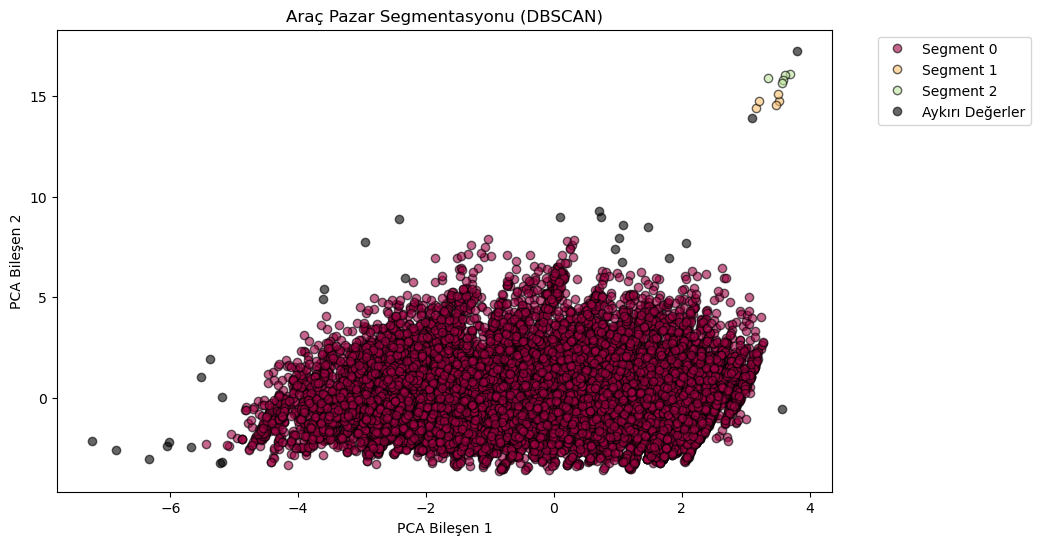

In [55]:
# Kümeleme (DBSCAN)
# PCA ile 2 boyuta indirip görselleştiriyoruz

print("Pazar Segmentasyonu için DBSCAN Kümeleme Analizi...")

# kümeleme mesafe temelli olduğu için scaled veri kullanıyoruz
# görselleştirmek için 2 boyuta indirgiyoruz (PCA)
pca_seg = PCA(n_components=2)
X_pca_seg = pca_seg.fit_transform(X_train_scaled) # Full scaled veri

# DBSCAN modeli
# eps: Komşuluk yarıçapı, min_samples: Bir küme oluşması için min nokta sayısı
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X_pca_seg)

# sonuçlar
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise = list(clusters).count(-1)

print(f"Tespit Edilen Segment (Küme) Sayısı: {n_clusters}")
print(f"Herhangi bir gruba uymayan (Aykırı) Araç Sayısı: {n_noise}")

# grafik
plt.figure(figsize=(10, 6))
unique_labels = set(clusters)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1] # Siyah renk gürültü/aykırı değerler
        label = "Aykırı Değerler"
    else:
        label = f"Segment {k}"

    class_member_mask = (clusters == k)
    xy = X_pca_seg[class_member_mask]
    
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6, label=label, alpha=0.6)

plt.title('Araç Pazar Segmentasyonu (DBSCAN)')
plt.xlabel('PCA Bileşen 1')
plt.ylabel('PCA Bileşen 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Modelin Tahmin Başarısı


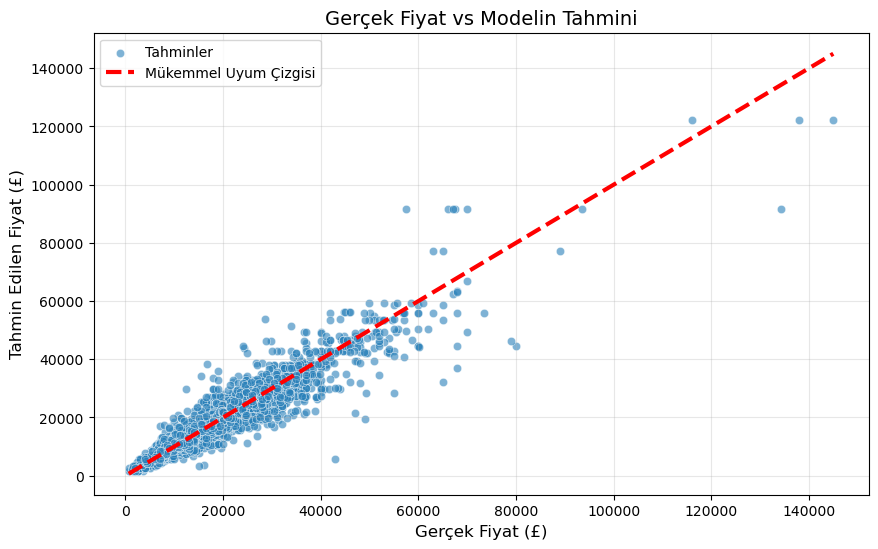

In [56]:
print("Modelin Tahmin Başarısı")

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=preds_opt, alpha=0.6, color='#2980b9', label='Tahminler')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3, label='Mükemmel Uyum Çizgisi')

plt.title('Gerçek Fiyat vs Modelin Tahmini', fontsize=14)
plt.xlabel('Gerçek Fiyat (£)', fontsize=12)
plt.ylabel('Tahmin Edilen Fiyat (£)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()